
## Generalized Advantage Estimation in Reinforcement Learning

### References:
[1] Schulman, J., Moritz, P., Levine, S., Jordan, M., & Abbeel, P. (2015). High-dimensional continuous control using generalized advantage estimation. arXiv preprint arXiv:1506.02438.


[2] The code in this notebook demo is adapted based on - https://colab.research.google.com/drive/1Wb_2zKgAqhI2tVK19Y1QC8AHImrzlcme?usp=sharing


#### **Problem Setting**

In this notebook, we consider a typical formulation of the policy optimization problem. The initial state $s_0$ is sampled from initial distribution $p_0$. A trajectory $(s_0, a_0, s_1, s_0, ...)$ is generated by sampling from policy $\pi(a_t|s_t)$. The states then transition from $s_t$ to $s_{t+1}$ from a sampled distribution of $P(s_{t+1}|s_t, a_t)$. A reward $r_t = r(s_t, a_t, s_{t+1})$ is dispensed at each time stamp. The goal is to maximize the expected total reward $\sum_{t=0}^{\infty}r_t$, which is assumed to be finite for all policies in this problem setting. 

Moreover, in this problem, we are not assuming a discount as part of the problem specification. It appears to be a controllable parameter that adjusts bias-variance tradeoff.

Policy gradient methods maximizes the expected total reward by estimating the policy gradient at each time stamp. The gradient which points to the direction where parameter $\theta$ in the policy term $\pi_\theta(a_t|s_t)$ is hard to be computed through a closed-form expression. We aim to demonstrate a method of estimating the policy gradient empirically through a set of trajectories.


#### **Policy Gradient**

We can be represented by

$$ g = \triangledown_{\theta} E[\sum_{t=0}^{\infty} r_t]. $$

The estimation of policy gradient through a set of trajectories is one of the most fundamental problems. In this problem settig, we assume that the policy gradient possess the following particular form:

$$ g = E[\sum_{t=0}^{\infty} A^{\pi}(s_t, a_t) \triangledown_\theta log \pi_{\theta}(a_t | s_t)], $$

where $A^{\pi}$ is the advantage of $(a_t, s_t)$ in comparisons to the average value function $V^{\pi}(s_t) = E_{s_{t+1}:\infty, a_t:\infty}[\sum_{l=0}^{\infty}r_{t+l}]$.

That is, $A^{\pi}(s_t, a_t) = Q^{\pi}(s_t, a_t) - V^{\pi}(s_t),$

where $Q^{\pi}(s_t, a_t) = E_{s_{t+1}:\infty, a_{t+1}:\infty}[\sum_{l=0}^{\infty}r_{t+l}]$. 

The difference between $Q^{\pi}(s_t, a_t)$ and $V^{\pi}(s_t)$ is that $Q^{\pi}(s_t, a_t)$ the expected return across all rollouts after taking action $a_t$ at $s_t$ whereas $V^{\pi}(s_t)$ is the expected return across all actions taken in $s_t$ resulting all subsequential rollouts. The advantage function is therefore the "advantage" of taking a specific action $a_t$ at $s_t$ in comparison to the average overall return of all actions to be taken at $s_t$.

The selection of $A^{\pi}(s_t, a_t)$ term as part of the policy gradient ensures that the gradient points in the direction of increased $\pi_{\theta}(a_t|s_t)$ if and only if $A^{\pi}(s_t, a_t) > 0$.

#### **Approximation of Policy Gradient**

We can introduce a parameter $\gamma$ in the estimation of $g$, denoted as $g^{\gamma}$, to control the bias-variance tradeoff in the estimation.

$$ g^{\gamma} = E[\sum_{t=0}^{\infty} A^{\pi, \gamma}(s_t, a_t) \triangledown_\theta log \pi_{\theta}(a_t | s_t)], $$

where $A^{\pi, \gamma}(s_t, a_t)$ is the discounted advantage function, which has form as

$$A^{\pi, \gamma}(s_t, a_t) = Q^{\pi, \gamma}(s_t, a_t) - V^{\pi, \gamma}(s_t).$$

$Q^{\pi, \gamma}(s_t, a_t), V^{\pi, \gamma}(s_t)$ are the discounted version of $Q^{\pi}(s_t, a_t), V^{\pi}(s_t)$, i.e.,

$$Q^{\pi, \gamma}(s_t, a_t) = E_{s_{t+1:\infty}, a_{t+1:\infty}}[\sum_{l=0}^\infty\gamma^l r_{t+l}]$$ 

,and

$$V^{\pi, \gamma}(s_t) = E_{s_{t+1:\infty}, a_{t:\infty}}[\sum_{l=0}^\infty\gamma^l r_{t+l}].$$


They have the exact same form as in the literature of discounted return in Reinforcement Learning. However, in this context, the purpose of the parameter $\gamma$ is to control the variability of value function at any state $s_t$ by introducing bias term.

Based on the above estimator $g^{\gamma}$, we want to estimate $g^{\gamma}$.


#### **Generalized Estimator of Advantage**

The target of Generalized Estimator of Advantage is to have

$$\hat{A}_t(s_{0:\infty}, a_{0;\infty})$$

such that 

$$E_{s_0:\infty,a_0:\infty}[\sum_{t=0}^{\infty}\hat{A}_t(s_{0:\infty}, a_{0;\infty})\triangledown_\theta log \pi_{\theta}(a_t | s_t)] = E[\sum_{t=0}^{\infty} A^{\pi, \gamma}(s_t, a_t) \triangledown_\theta log \pi_{\theta}(a_t | s_t)].$$

Note that we already introduced bias to the estimation of policy gradient when we replace $A^{\pi}$ by $A^{\pi, \gamma}$. Here we only consider an unbiased estimator of $g^{\gamma}$, which is a biased estimate of policy gradient of undiscounted MDP.

Suppose that $V$ is an approximate value function, we define TD residuals $\delta_t^V = r_t + \gamma V(s_{t+1}) - V(s_t)$ where $\gamma$ is the discount factor. $\delta_t^V$ can be considered as an estimate of the advantage of the action $a_t$. If we have the correct value function $V = V^{\pi, \gamma}$, we can easily show that 

$$E_{s_{t+1}}[\delta_t^{V^{\pi, \gamma}}] = E_{s_{t+1}}[Q^{\pi,\gamma}(s_t,a_t) - V^{\pi, \gamma}(s_t)] = A^{\pi, \gamma}(s_t, a_t).$$

However, it is not unbiased estimator if $V \neq V^{\pi, \gamma}$, which means that using TD residual would introduce bias unless we know the exact value function.

Consider a general $k$ sums of these TD residuals,

$$\hat{A}_t^{(1)} = \delta_t^V = -V(s_t) + r_t + \gamma V(s_{t+1})$$
$$\hat{A}_t^{(2)} = \delta_t^V + \gamma \delta_{t+1}^V = -V(s_t) + r_t + \gamma r_{t+1} + \gamma^2 V(s_{t+1})$$
$$\hat{A}_t^{(k)} = \sum_{l=0}^{k-1} \gamma^l \delta_{t+l}^V = -V(s_t) + r_t + \gamma r_{t+1} + ... + \gamma^{k-1} r_{t+k-1} + \gamma^kV(s_{t+k})$$

An importan obervasion is that as $k$ becomes larger, the bias introduced by inaccurate value function $V$ gets smaller and smaller. As $k \rightarrow \infty$,

$$\hat{A}_t^{\infty} = \sum_{l=0}^{\infty} \gamma^l \delta_{t+l}^V = -V(s_t) + \sum_{l=0}^{\infty} \gamma^l r_{t+l}.$$

Recall that $A^{\pi, \gamma} = Q^{\pi, \gamma}(s_t,a_t) - V^{\pi, \gamma}(s_t) = E_{s_{t+1:\infty}, a_{t+1:\infty}}[\sum_{l=0}^{\infty} \gamma^l r_{t+l}] - V^{\pi, \gamma}(s_t)$.

Comparing these two above equations, we can find that taking expectation of $\hat{A}_t^{\infty}$ would result in expectation of $A^{\pi, \gamma}$, regardless of the choice of $V$ by Proposition 1 in the paper.

**Prop. 1** Suppose that $\hat{A}_t$ can be written in the form $\hat{A}_t(s_{0:\infty},a_{0:\infty}) = Q_t(s_{t:\infty}, a_{t:\infty}) - b_t(s_{0:t}, a_{0:{t-1}})$ such that for all $(s_t, a_t)$, $E_{s_{t+1:\infty},a_{t+1:\infty}}[Q_t(s_{t:\infty},a_{t:\infty})] = Q^{\pi, \gamma}(s_t, a_t). Then, E_{s_{0:\infty},a_{0:\infty}}[\hat{A}_t(s_{0:\infty},a_{0:\infty})] = E_{s_{0:\infty},a_{0:\infty}}[A^{\pi, \gamma}(s_t,a_t)]$.

To further control the bias-varaince tradeoff with estimator $A^{\infty}_t$
Therefore, an enhancement of the above estimator is to use exponentially-weighted sum of $k$-step estimator:

$$\hat{A}^{GAE(\gamma,\lambda)} = (1-\lambda)(\hat{A}^{(1)}_t + \lambda \hat{A}^{(2)}_t + ...) = \sum_{l=0}^{\infty} (\gamma \lambda)^l \delta_{t+l}^V$$

Note that when $\lambda = 0$, $\hat{A}^{GAE(\gamma,0)}$ is reduced to $\delta_t = r_t + \gamma V(s_{t+1}) - V(s_t)$, which as discussed above is biased unless $V = V^{\pi, \gamma}$. When $\lambda = 1$, $\hat{A}^{GAE(\gamma,0)} = A_t^{\infty}$ which has expectation equal to the expectation of $A^{\pi, \gamma}$.


**Some Transition Dynamics**

Here we demonstrate our findings with the estimator $A^{\pi, \gamma}(s_t, a_t)$ for $A^{\pi}(s_t, a_t)$, and estimator $\hat{A}^{GAE(\gamma, \lambda)}$ for $A^{\pi, \gamma}(s_t, a_t)$ in a simple set up.

We will use an episodic five state chain environment. At the beginning of an episode, the agent starts in state $s_1$. In each state, it can take an action $a \in \{\texttt{left}, \texttt{right}\}$ which will deterministically move it into the corresponding next state. When the agent reaches either one of states $s_0$ or $s_6$ the episode ends. The agent receives zero rewards at all transitions, except when it takes the $\texttt{right}$ action in state $s_5$ where it receives a reward of one. Throughout the notebook, we use $\mathcal{S} = \{s_0, s_1, s_2, s_3, s_4, s_5, s_6\}$ to denote the state set and $\mathcal{A} = \{\texttt{left}, \texttt{right}\}$ to denote the action set.



# Environment: Linear Chain
We will use an episodic five state chain environment, as shown **below**. At the beginning of an episode, the agent starts in state $s_1$. In each state, it can take an action $a \in \{\texttt{left}, \texttt{right}\}$ which will deterministically move it into the corresponding next state. When the agent reaches either one of states $s_0$ or $s_6$ the episode ends. The agent receives zero rewards at all transitions, except when it takes the $\texttt{right}$ action in state $s_5$ where it receives a reward of one. Throughout the notebook, we use $\mathcal{S} = \{s_0, s_1, s_2, s_3, s_4, s_5, s_6\}$ to denote the state set and $\mathcal{A} = \{\texttt{left}, \texttt{right}\}$ to denote the action set.

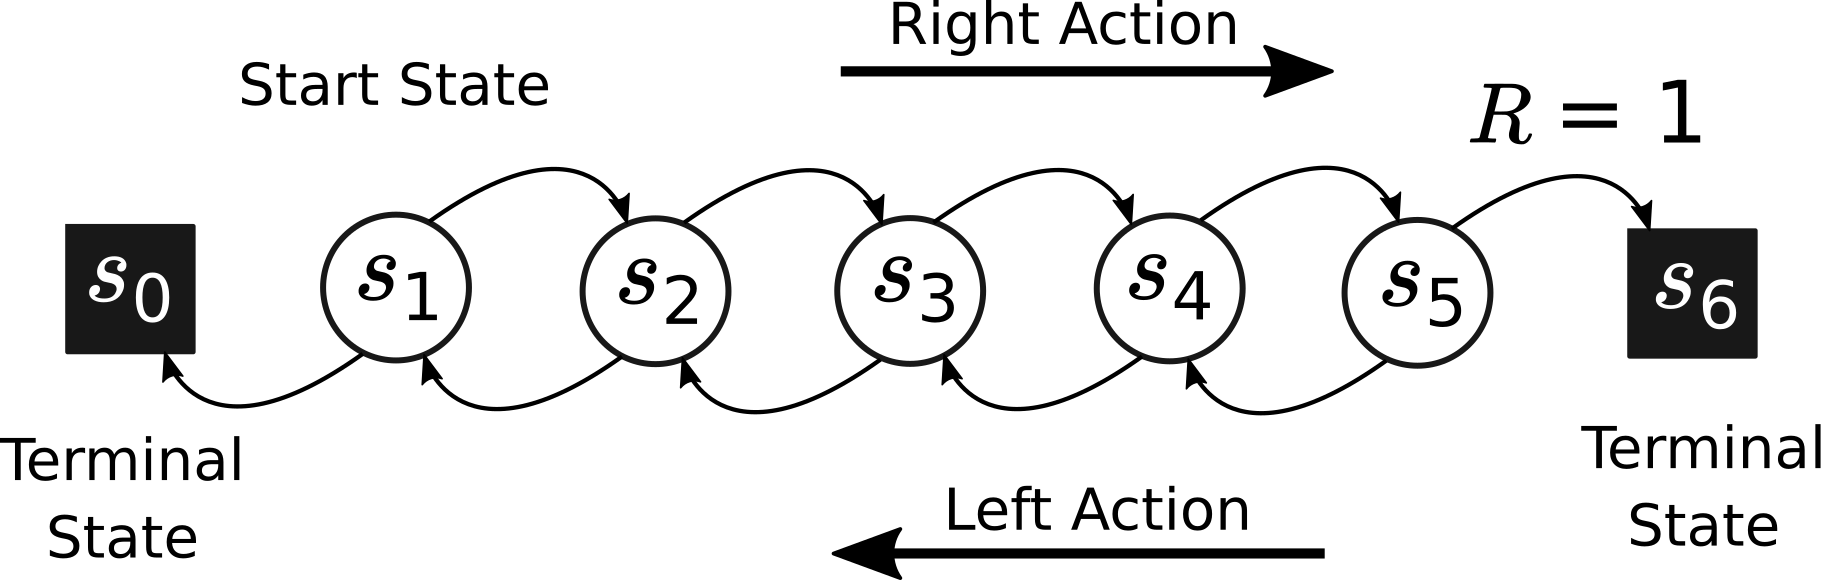

## Matrices $\boldsymbol{P}, \boldsymbol{r}$, and $\boldsymbol{\pi}$

* $\boldsymbol{P}$ is the transition probability matrix. It is a 3D matrix of size $|\mathcal{A}| \times |\mathcal{S}| \times |\mathcal{S}|$, where the $(i, j, k)$th element corresponds to $\Pr\{S_{t+1} = s_k \;|\; S_t = s_j, A_t = a_i\}$.

* $\boldsymbol{r}$ is the reward matrix of size $|\mathcal{S}| \times |\mathcal{A}|$ where the $(i, j)$th element is equal to $r(s_i, a_j)$.

* $\boldsymbol{\pi}$ is a matrix, of size $|\mathcal{S}| \times |\mathcal{A}|$, representing the policy of the agent where the $(i, j)$th element is equal to $\pi(a_j|s_i)$.

We will later pass the matrices $\boldsymbol{P}$ and $\boldsymbol{r}$ to define the `LinearChain()` environment. 

For a detailed introduction to vector notation in RL, please see (Agarwal et al., 2020).

In [183]:
import numpy as np
import time
import matplotlib.pyplot as plt
from itertools import chain

In [184]:
P = np.array([[[1, 0, 0, 0, 0, 0, 0],    # s_0 terminal \
               [1, 0, 0, 0, 0, 0, 0],    # s_1           |
               [0, 1, 0, 0, 0, 0, 0],    # s_2           |
               [0, 0, 1, 0, 0, 0, 0],    # s_3           |-> for action a_0 i.e. left          
               [0, 0, 0, 1, 0, 0, 0],    # s_4           |
               [0, 0, 0, 0, 1, 0, 0],    # s_5           |
               [0, 0, 0, 0, 0, 0, 1]],   # s_6 terminal /
              
              [[1, 0, 0, 0, 0, 0, 0],    # s_0 terminal \
               [0, 0, 1, 0, 0, 0, 0],    # s_1           |
               [0, 0, 0, 1, 0, 0, 0],    # s_2           |
               [0, 0, 0, 0, 1, 0, 0],    # s_3           |-> for action a_1 i.e. right
               [0, 0, 0, 0, 0, 1, 0],    # s_4           |
               [0, 0, 0, 0, 0, 0, 1],    # s_5           |
               [0, 0, 0, 0, 0, 0, 1]]])  # s_6 terminal /
#  State:       0  1  2  3  4  5  6

r = np.array([[0, 0],  # s_0
              [0, 0],  # s_1
              [0, 0],  # s_2
              [0, 0],  # s_3
              [0, 0],  # s_4
              [0, 1],  # s_5
              [0, 0]]) # s_6
# Action:    a_0  a_1

pi = np.array([[0.5, 0.5],  # s_0
               [0.5, 0.5],  # s_1
               [0.5, 0.5],  # s_2
               [0.5, 0.5],  # s_3
               [0.5, 0.5],  # s_4
               [0.5, 0.5],  # s_5
               [0.5, 0.5]]) # s_6
# Action:       a_0  a_1

tabular_features = np.array([[0, 0, 0, 0, 0],  # s_0 terminal
                             [1, 0, 0, 0, 0],  # s_1
                             [0, 1, 0, 0, 0],  # s_2  
                             [0, 0, 1, 0, 0],  # s_3
                             [0, 0, 0, 1, 0],  # s_4
                             [0, 0, 0, 0, 1],  # s_5
                             [0, 0, 0, 0, 0]]) # s_6 terminal

Given a linear chain, the step function will calculate the next stochastic state and reward automatically based on the action and the transition dynamics.

In [185]:
class LinearChain():
    def __init__(self, P, r, start_state, terminal_states, noise=0):
        self.P = P
        self.r = r
        self.noise = noise
        self.n = P.shape[-1]
        self.start_state = start_state
        self.terminal_states = terminal_states

        self.observation_space = self.n
        self.action_space = 2
        self.state = None

        self.t = 0

    def reset(self):
        self.state = self.start_state
        return self.state

    def step(self, action):
        if self.state is None:
            raise Exception('step() used before calling reset()')
        assert action in range(P.shape[0])

        reward = r[self.state, action] \
            + np.random.normal(loc=0, scale=self.noise)
        self.state = np.random.choice(a=self.n, p=self.P[action, self.state])
        self.t = self.t + 1

        done = False
        if self.state in self.terminal_states:
            done = True

        return self.state, reward, done, {}

    def calc_v_pi(self, pi, gamma):
        # calculate P_pi from the transition matrix P and the policy pi
        P_pi = np.zeros(self.P[0].shape)
        for a in range(pi.shape[1]):
            P_pi += self.P[a] * pi[:, a].reshape(-1, 1)

        # calculate the vector r_pi
        r_pi = (self.r * pi).sum(1).reshape(-1, 1)

        # calculate v_pi using the equation given above
        v_pi = np.matmul(
            np.linalg.inv(np.eye(self.P.shape[-1]) - gamma * P_pi), 
            r_pi)

        return v_pi

    # Calculate the ground truth state-action value function based on the 
    # ground truth state value function.
    def calc_q_pi(self, pi, gamma):
        # First calcuate the ground truth value vector.
        v_pi = self.calc_v_pi(pi, gamma)
        q_pi = self.r + gamma * (self.P @ v_pi)[:, :, 0].T
        return q_pi

In [186]:
class Agent():

    def __init__(self, num_actions, policy_features, value_features,
                 policy_stepsize, value_stepsize, nstep, lambda_, gamma,
                 FLAG_BASELINE, FLAG_POPULAR_PG=False):
        self.policy_features = policy_features
        self.value_features = value_features
        self.num_actions = num_actions

        self.policy_weight = np.zeros((policy_features.shape[1],
                                       num_actions))
        if value_features is None:
            self.value_weight = None
        else:
            self.value_weight = np.asarray([[-0.04230291],
                                            [ 0.139734  ],
                                            [ 0.14239203],
                                            [ 0.00787976],
                                            [ 0.91098493]])
            # self.value_weight = np.zeros((value_features.shape[1], 1))

        self.policy_stepsize = policy_stepsize
        self.value_stepsize = value_stepsize

        self.FLAG_BASELINE = FLAG_BASELINE
        self.FLAG_POPULAR_PG = FLAG_POPULAR_PG
        self.gamma = gamma
        # Parameter for calculating the generalized advantage.
        self.lambda_ = lambda_
        self.nstep = nstep

        self.pi = None
        self.FLAG_POLICY_UPDATED = True

    @staticmethod
    def softmax(x):
        e_x = np.exp(x - np.max(x, 1).reshape(-1, 1))
        out = e_x / e_x.sum(1).reshape(-1, 1)
        return out

    # At a given state, use the existing stochastic policy to decide which 
    # action to take.
    def take_action(self, state):
        if self.FLAG_POLICY_UPDATED:
            action_prefs = np.matmul(self.policy_features, self.policy_weight)
            self.pi = self.softmax(action_prefs)
            self.FLAG_POLICY_UPDATED = False
            
        action = np.random.choice(self.num_actions, p=self.pi[state])
        return action, self.pi[state, action]

    # Use the current value functions to make predictions.
    def calc_v_pi_pred(self):
        return np.matmul(self.value_features, self.value_weight)

    # =========================================================================
    # Calculate the advantage for a specific step.
    def calc_TD(self, curr_state, next_state, reward):
        return reward + (self.value_features[next_state] @ self.value_weight - \
                         self.value_features[curr_state] @ self.value_weight)

    # Calculate GAE based on infinite horizon with absorbing states (s_0 and 
    # s_6). In the absorbing states though, the value function and the reward 
    # stay to be 0 and thus the TD at each absorbing step is also 0.
    def calc_generalized_advantage(self, t, traj, v_pi, q_pi):
        reward_list = traj['reward_list']
        next_state_list = traj['next_state_list']
        state_list = traj['state_list']
        action_list = traj['action_list']
        traj_length = len(reward_list)

        GAE = 0
        discount = 1
        for i in range(t, traj_length):
            GAE += discount * self.calc_TD(state_list[i], 
                                           next_state_list[i], 
                                           reward_list[i])
            discount *= self.gamma * self.lambda_
            # discount *= self.gamma * 100

        # Calculate the ground truth unbiased advantage based on the ground
        # truth state action value function and state value function.
        true_advantage = q_pi[state_list[t], action_list[t]] - \
                         v_pi[state_list[t]]
            
        return GAE, true_advantage
    # =========================================================================
    

    # helper function for calculating the policy gradient.
    def calc_grad_log_pi(self, state, action):
        x = self.policy_features[state].reshape(-1, 1)
        action_prefs = np.matmul(x.T, self.policy_weight)
        pi = self.softmax(action_prefs).T

        I_action = np.zeros((self.num_actions, 1))
        I_action[action] = 1

        one_vec = np.ones((1, self.num_actions))

        return np.matmul(x, one_vec) * (I_action - pi).T

    # Calculate the GAE based policy gradient estimator or
    # calculate the true advantage based policy gradient.
    def calc_gae_pg(self, trajs, v_pi, q_pi, estimate=True):
        policy_grad = np.zeros(self.policy_weight.shape)
        for traj in trajs:
            state_list = traj['state_list']
            action_list = traj['action_list']
            traj_length = len(state_list)
            
            for t in range(traj_length):
                state = state_list[t]
                action = action_list[t]
                GAE, true_advantage = self.calc_generalized_advantage(t, traj, v_pi, q_pi)
                grad_log_pi = self.calc_grad_log_pi(state, action)
                
                if self.FLAG_BASELINE:
                    baseline = v_pi[state]
                else:
                    baseline = 0
                # policy_grad += self.gamma**t * GAE * grad_log_pi
                if estimate == True:
                    policy_grad += GAE * grad_log_pi
                else:
                    policy_grad += true_advantage * grad_log_pi

        return policy_grad / len(trajs)


The algorithm for calculating GAE at each time step of the trajectory is as follows:

For each $lambda$
>Loop for $num\_samples$

>> Loop for $num\_episodes$


>>> Sample an episode $S_0, A_0, R_1, \ldots, S_{T-1}, A_{T-1}, R_T, S_T$ from the environment using the policy $\pi_\boldsymbol{\theta}$

>>> For each step of the episode $t = 0, 1, \ldots, T-1$:

>>>> Calculate: \\
**a**. GAE based on the infinite horizon, i.e., $\hat{A}^{GAE(\gamma,\lambda)}(a_t, s_t) = \sum_{l=0}^{\infty} (\gamma \lambda)^l \delta_{t+l}^V$; \\
**b**. The ground truth advantage, i.e., $Q^{\pi, \gamma}(s_t, a_t) - V^{\pi, \gamma}(s_t)$ (using the ground truth state value function and state-action value function)



>> Based on the GAEs along the $num\_episodes$ trajectories, calculate the policy gradient estimate $\nabla_{\boldsymbol{\theta}} 
\hat{J}^{GAE} = \frac{1}{N}\sum_{n=1}^{N}\sum_{t=0}^{\infty} \left\{\left[\hat{A}^{GAE(\gamma,\lambda)}(a_t, s_t)\right] \nabla_{\boldsymbol{\theta}} \log \pi_{\boldsymbol{\theta}}(A_t | S_t)\right\}$ where $N=num\_episodes$.

> Based on the ground truth advantage at each step and a much larger sample size, calculate the true gradient $\nabla_{\boldsymbol{\theta}} 
J = \frac{1}{N'}\sum_{n=1}^{N'}\sum_{t=0}^{\infty} \left\{\left[Q^{\pi, \gamma}(s_t, a_t) - V^{\pi, \gamma}(s_t)\right] \nabla_{\boldsymbol{\theta}} \log \pi_{\boldsymbol{\theta}}(A_t | S_t)\right\}$ where $N'=num\_episodes \times num\_samples$.

---

For each feature of the policy gradient, the square bias is calculated to be:
$$
bias^2 = \left\{\mathbb{E}\left[\nabla_{\boldsymbol{\theta}} 
\hat{J}^{GAE}\right] - \nabla_{\boldsymbol{\theta}} 
J\right\}^2
$$
Also for each feature of the policy gradient, the variance is calculated to be:
$$
var = \mathbb{E}\left\{\left[ \nabla_{\boldsymbol{\theta}} 
\hat{J}^{GAE} - \mathbb{E}\left[\nabla_{\boldsymbol{\theta}} 
\hat{J}^{GAE}\right] \right]^2\right\}
$$
And the sum of the two terms is the Mean Squared Error:
$$
MSE = bias^2 + var
$$

In [187]:
def run_experiment(num_runs, num_episodes,
                   P, r, start_state, terminal_state,
                   num_actions, policy_features, value_features,
                   policy_stepsize, value_stepsize, nstep, lambdas, gamma,
                   FLAG_BASELINE, FLAG_LEARN_VPI, reward_noise=0, vpi_bias=0):
    bias_ = []
    variances = []

    for lambda_ in lambdas:
        np.random.seed(0) 

        # define agent and the environment
        env = LinearChain(P, r, start_state, terminal_states, reward_noise)

        agent = Agent(num_actions, policy_features, value_features,
                    policy_stepsize, value_stepsize, nstep, lambda_, gamma,
                    FLAG_BASELINE)

        return_across_episodes = []
        ep_len_across_episodes = []
        vpi_across_episodes = []

        sample_trajs = []
        grad_estimators = []
        for sample in range(num_samples):

            episode_trajs = []
            for episode in range(num_episodes):

                traj = {'state_list': [],
                        'action_list': [],
                        'action_prob_list': [],
                        'reward_list': [],
                        'next_state_list': []}

                # sample a trajectory from following the current policy
                done = False
                state = env.reset()
                while not done:
                    action, action_prob = agent.take_action(state)
                    next_state, reward, done, _ = env.step(action)

                    traj['state_list'].append(state)
                    traj['action_list'].append(action)
                    traj['action_prob_list'].append(action_prob)
                    traj['reward_list'].append(reward)
                    traj['next_state_list'].append(next_state)

                    state = next_state
                
                # Set v_pi to always be the ground truth. Since in the GAE setting, 
                # estimated v_pi can be calculated using the newly defined helper 
                # function `cal_TD`, so the ground truth v_pi can be used to 
                # calculate the ground truth unbiased advantage, for the later use
                # of bias-variance calculation.
                v_pi = env.calc_v_pi(agent.pi, gamma)
                q_pi = env.calc_q_pi(agent.pi, gamma)


                # Update the trajectory lists.
                episode_trajs.append(traj)
                sample_trajs.append(traj)

            grad_estimators.append(agent.calc_gae_pg(episode_trajs, v_pi, q_pi))
        
        true_gradient = agent.calc_gae_pg(sample_trajs, v_pi, q_pi, estimate=False)

        bias = (np.mean(np.asarray(grad_estimators), axis=0) - true_gradient) ** 2
        variance = np.var(np.asarray(grad_estimators), axis=0)
        bias_.append(bias)
        variances.append(variance)

        # print("Lambda {}".format(lambda_))
    bias_ = np.asarray(bias_)
    variances = np.asarray(variances)
    plt.plot(lambdas, bias_[:, 0, 0], label="bias")
    plt.plot(lambdas, variances[:, 0, 0], label="variance")
    plt.plot(lambdas, bias_[:, 0, 0] + variances[:, 0, 0], label="MSE")
    plt.legend()
    plt.title("bias-variance tradeoff for the (0, 0) entry of policy gradients")
    plt.show()

    plt.plot(lambdas, bias_[:, 0, 1], label="bias")
    plt.plot(lambdas, variances[:, 0, 1], label="variance")
    plt.plot(lambdas, bias_[:, 0, 1] + variances[:, 0, 1], label="MSE")
    plt.legend()
    plt.title("bias-variance tradeoff for the (0, 1) entry of policy gradients")
    plt.show()


    return

In [188]:
num_runs = 10
num_episodes = 20
num_samples = 50

start_state = 1
terminal_states = [0, 6]
reward_noise = 0.3
gamma = 0.5
lambdas = np.linspace(0.5, 0.99, 10)

num_actions = 2
FLAG_BASELINE = True

# nstep_list = [1, 2, 4, 16, 'inf']
# stepsize_list = [0.1, 0.3, 0.5, 0.7, 1]
nstep_list = [16]
stepsize_list = [0.1]

Starting the experiments. Estimated time to completion: 1000 seconds
nstep: 16


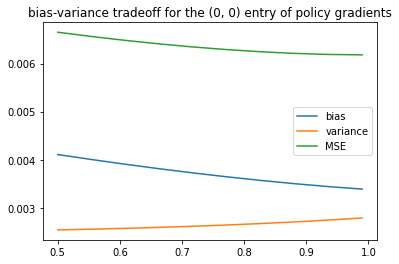

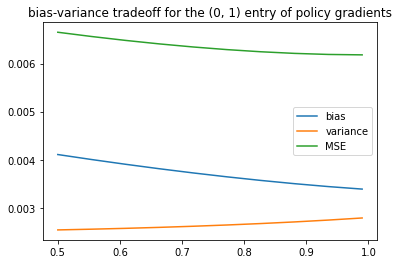

nstep: 16	time elapsed: 22s


In [189]:
FLAG_LEARN_VPI = True
value_features = tabular_features
policy_features = tabular_features

tic = time.time()
exp_data1 = dict()
print('Starting the experiments. Estimated time to completion: 1000 seconds')
for nstep in nstep_list: 
    print("nstep: {}".format(nstep))
    exp_data1[nstep] = dict()
    for stepsize in stepsize_list:
        policy_stepsize = stepsize
        value_stepsize = stepsize

        dat = run_experiment(num_runs, num_episodes,
                             P, r, start_state, terminal_states,
                             num_actions, policy_features, value_features,
                             policy_stepsize, value_stepsize, nstep, lambdas, gamma, 
                             FLAG_BASELINE, FLAG_LEARN_VPI, reward_noise)
        
        exp_data1[nstep][stepsize] = dat
    print('nstep: {}\ttime elapsed: {:.0f}s'.format(nstep, time.time() - tic)) 

# Summary



*   In this presentation, we introduced Generalized Advantage Estimators for approximating the true advantage;
* Through the experiment, we showed that we can use GAE to estimate policy gradients;
*  The parameter lambda controls the bias-variance tradeoff of the policy gradient estimator - with lambda being increased, the bias should get smaller but the variance should get larger.

